In [3]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/drive/MyDrive/data/Training")
img_as_jpg = list(path.glob(r"*/*.jpg"))


file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
glioma = file_count.count('glioma_tumor')
meningioma = file_count.count('meningioma_tumor')
no_tum = file_count.count('no_tumor')
pituitary = file_count.count('pituitary_tumor')

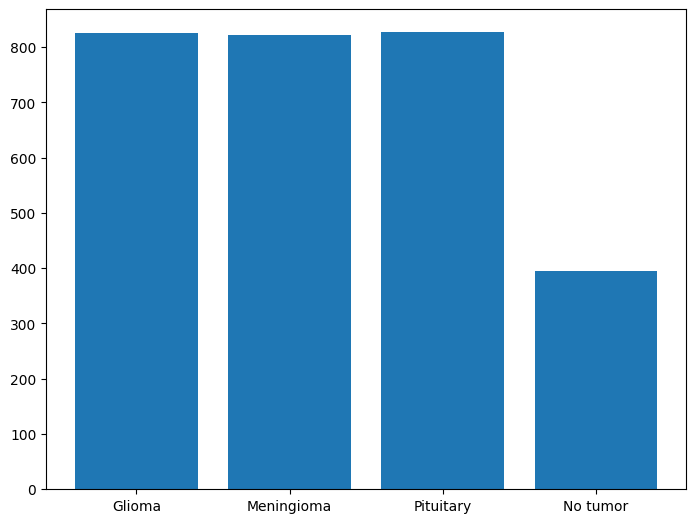

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Glioma','Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, no_tum]
ax.bar(labels, count_train)
plt.show()

In [ ]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(2870, 2)


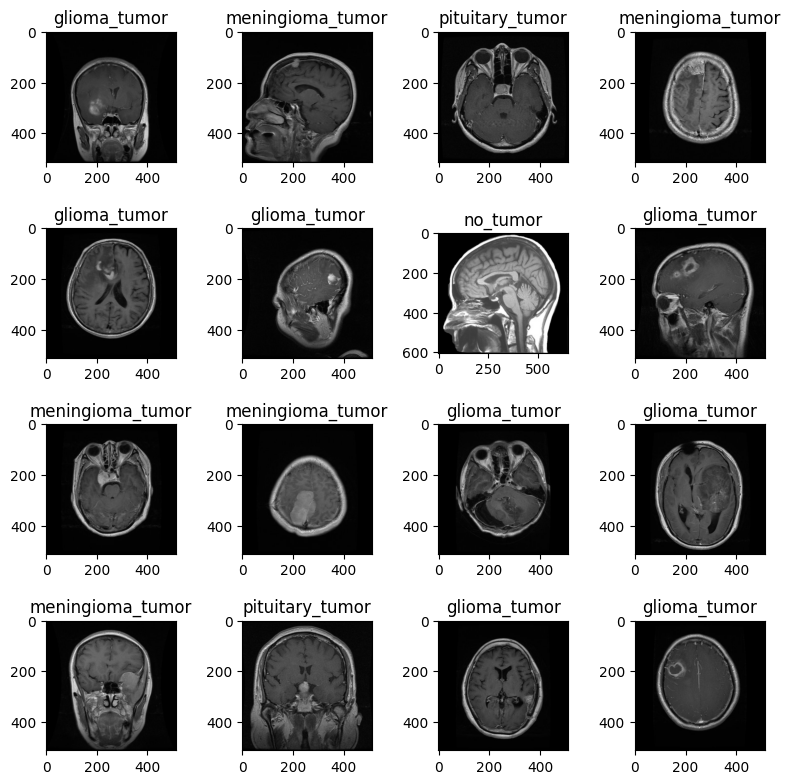

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

In [ ]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/data/Training", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
ds1 = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/data/Testing", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
model.fit(train_ds, epochs=20, validation_data=validation_ds)

Epoch 1/20
36/36 [==============================] - 104s 3s/step - loss: 0.6380 - accuracy: 0.7444 - balanced_sparse_categorical_accuracy: 0.7480 - val_loss: 0.5224 - val_accuracy: 0.8057 - val_balanced_sparse_categorical_accuracy: 0.8141
Epoch 2/20
36/36 [==============================] - 100s 3s/step - loss: 0.5106 - accuracy: 0.7977 - balanced_sparse_categorical_accuracy: 0.7992 - val_loss: 0.5436 - val_accuracy: 0.7880 - val_balanced_sparse_categorical_accuracy: 0.7916
Epoch 3/20
36/36 [==============================] - 101s 3s/step - loss: 0.4185 - accuracy: 0.8385 - balanced_sparse_categorical_accuracy: 0.8388 - val_loss: 0.4133 - val_accuracy: 0.8251 - val_balanced_sparse_categorical_accuracy: 0.8270
Epoch 4/20
36/36 [==============================] - 109s 3s/step - loss: 0.3432 - accuracy: 0.8715 - balanced_sparse_categorical_accuracy: 0.8695 - val_loss: 0.3569 - val_accuracy: 0.8693 - val_balanced_sparse_categorical_accuracy: 0.8833
Epoch 5/20
36/36 [==========================

1/1 [==============================] - 1s 585ms/step


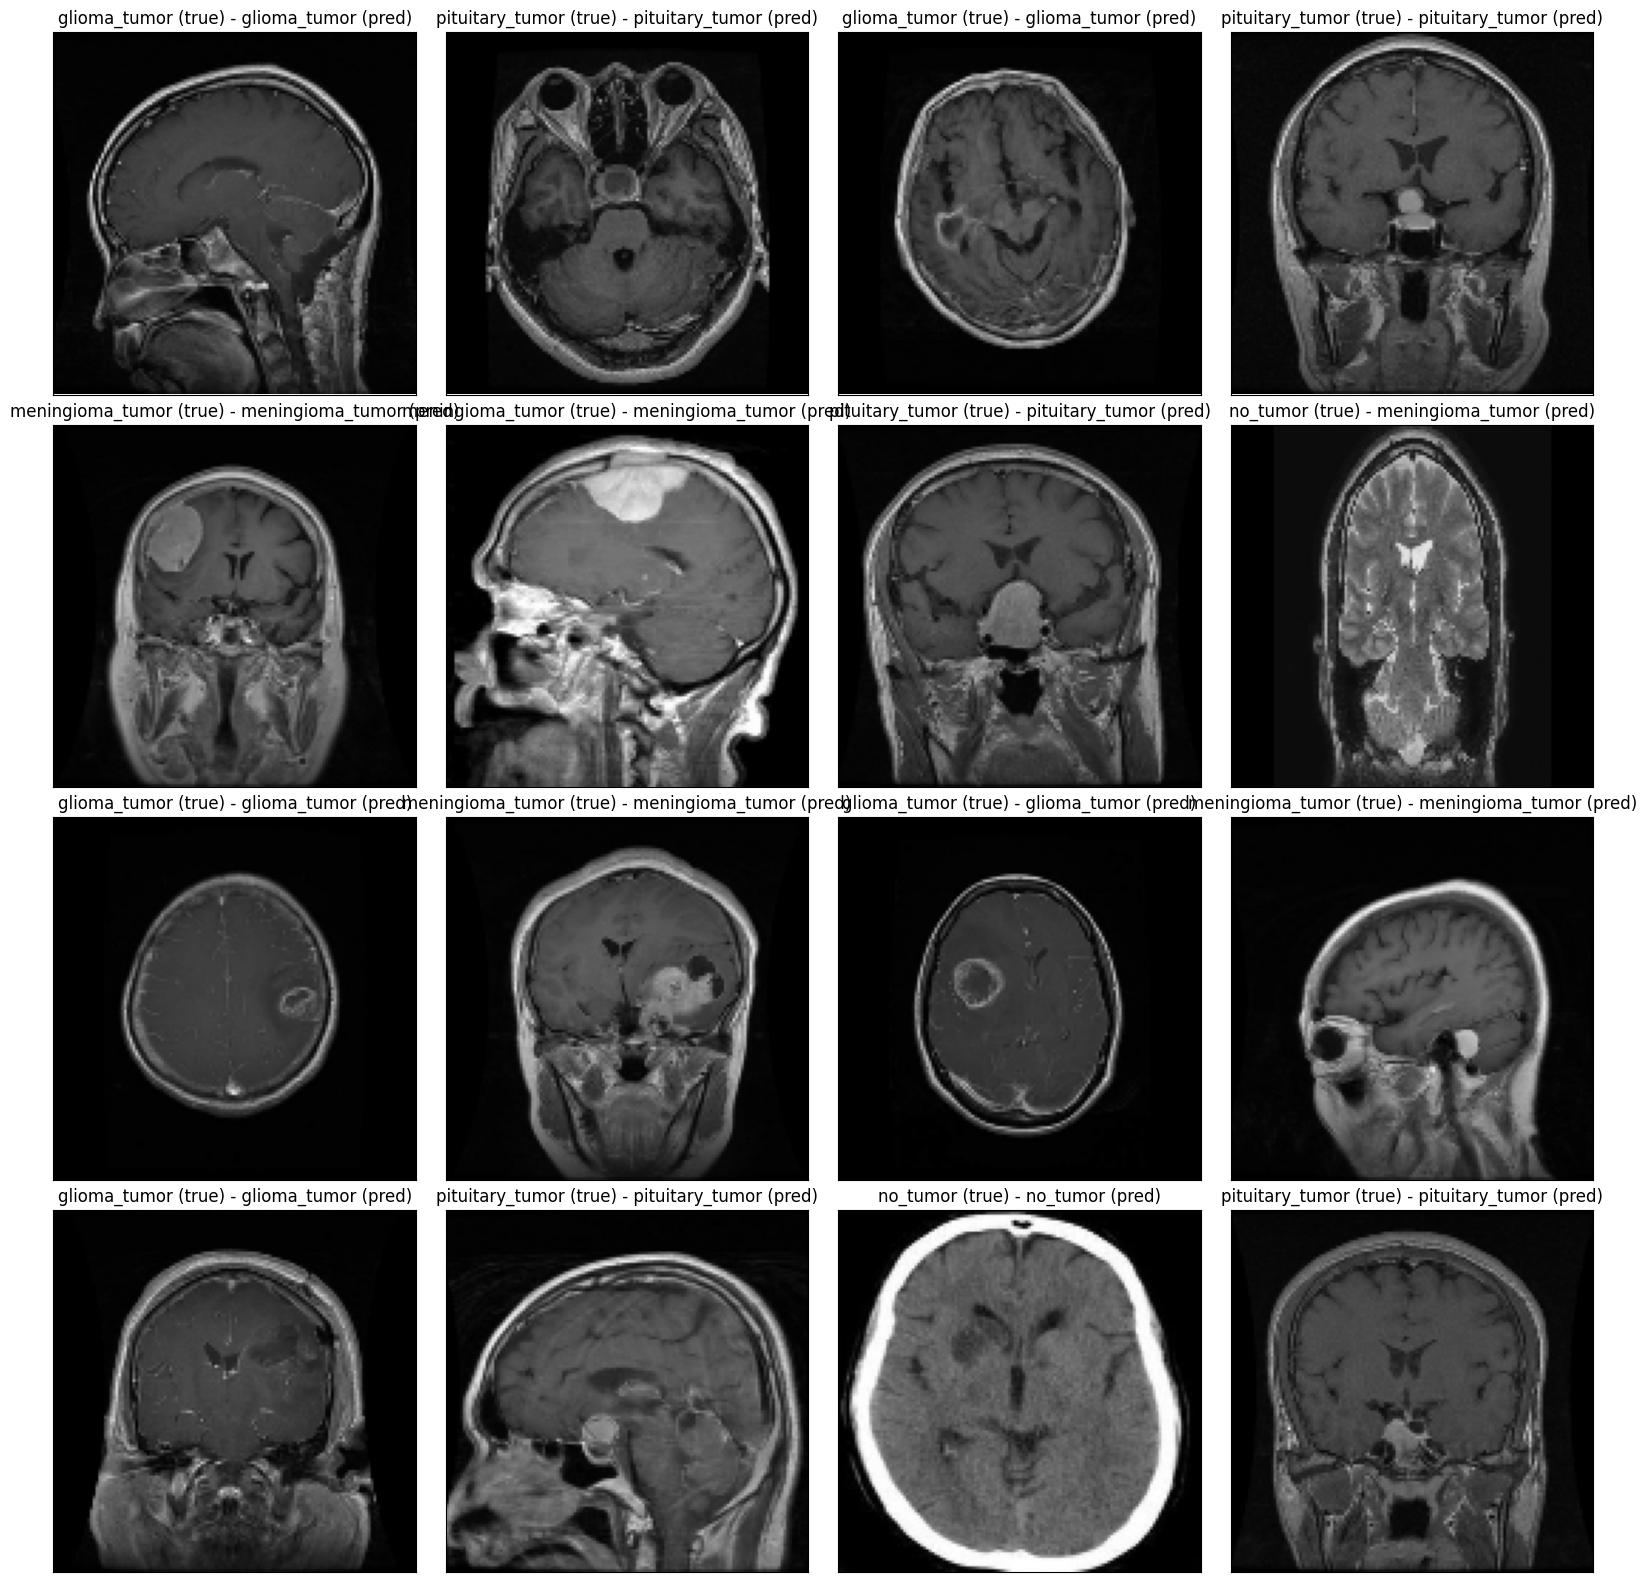

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
model.save("models/ViT_on_20_epochs.model")

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

from sklearn.metrics import precision_score, recall_score


precision = precision_score(y_true, y_hat, average=None)

recall = recall_score(y_true, y_hat, average=None)

for i in range(len(precision)):
    print(f"Precision for class {i}: {precision[i]}")
    print(f"Recall for class {i}: {recall[i]}")


Precision for class 0: 0.9871794871794872
Recall for class 0: 0.9808917197452229
Precision for class 1: 0.9580838323353293
Recall for class 1: 0.9696969696969697
Precision for class 2: 0.9726027397260274
Recall for class 2: 0.9594594594594594
Precision for class 3: 0.9823529411764705
Recall for class 3: 0.9823529411764705


In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")
model.save("models/ViT_on_10_epochs.model")

Final accuracy on validation set : 0.973


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model


class BalancedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_sparse_categorical_accuracy', **kwargs):
        super(BalancedSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
        values = tf.reduce_sum(tf.cast(values, 'float32'))
        self.total.assign_add(values)
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return self.total / self.count


model = load_model('models/ViT_on_20_epochs.model', custom_objects={'BalancedSparseCategoricalAccuracy': BalancedSparseCategoricalAccuracy})


new_train_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/data/Training", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size) # Load and preprocess the new training dataset
new_validation_ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/data/Testing", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)  # Load and preprocess the new validation dataset


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
)


history = model.fit(new_train_ds, validation_data=new_validation_ds, epochs=10)


Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.
Epoch 1/10
45/45 [==============================] - 252s 5s/step - loss: 0.1474 - accuracy: 0.9610 - balanced_sparse_categorical_accuracy: 17.6495 - val_loss: 2.3227 - val_accuracy: 0.6980 - val_balanced_sparse_categorical_accuracy: 16.7005
Epoch 2/10
45/45 [==============================] - 106s 2s/step - loss: 0.0706 - accuracy: 0.9774 - balanced_sparse_categorical_accuracy: 17.6774 - val_loss: 3.6425 - val_accuracy: 0.7259 - val_balanced_sparse_categorical_accuracy: 17.2589
Epoch 3/10
45/45 [==============================] - 108s 2s/step - loss: 0.0643 - accuracy: 0.9777 - balanced_sparse_categorical_accuracy: 17.8258 - val_loss: 2.4819 - val_accuracy: 0.7513 - val_balanced_sparse_categorical_accuracy: 17.0558
Epoch 4/10
45/45 [==============================] - 107s 2s/step - loss: 0.0506 - accuracy: 0.9836 - balanced_sparse_categorical_accuracy: 17.6892 - val_loss: 2.8225 - val_accuracy: 0.7360 - val_b

1/1 [==============================] - 0s 391ms/step


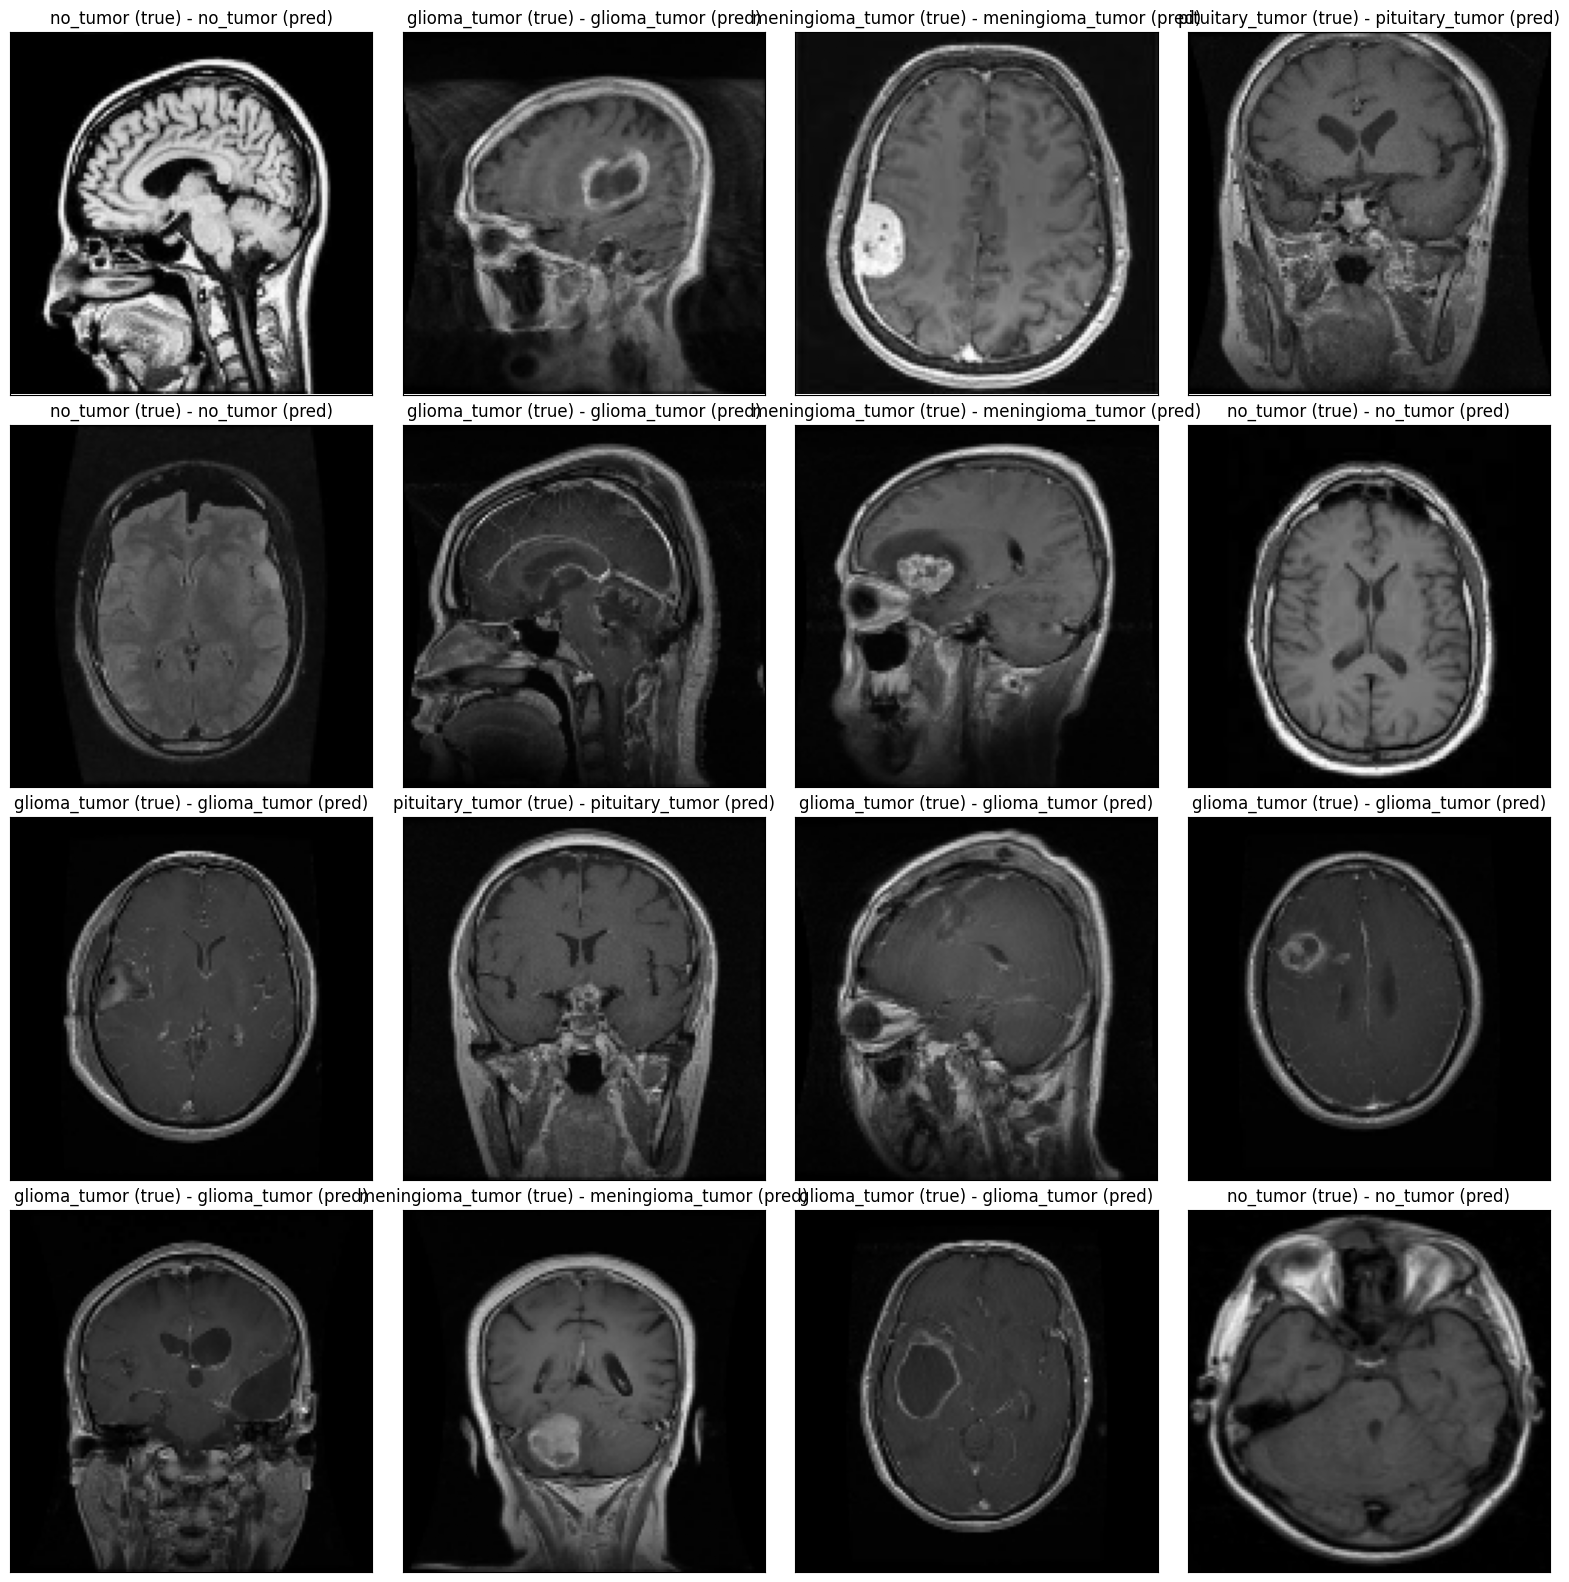

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))


In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

from sklearn.metrics import precision_score, recall_score


precision = precision_score(y_true, y_hat, average=None)


recall = recall_score(y_true, y_hat, average=None)

for i in range(len(precision)):
    print(f"Precision for class {i}: {precision[i]}")
    print(f"Recall for class {i}: {recall[i]}")

Precision for class 0: 1.0
Recall for class 0: 0.9794520547945206
Precision for class 1: 0.9876543209876543
Recall for class 1: 0.9696969696969697
Precision for class 2: 0.9367088607594937
Recall for class 2: 1.0
Precision for class 3: 0.9945054945054945
Recall for class 3: 1.0


In [ ]:
model.save("models/ViTenhanced_on_10_epochs.model")

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")
model.save("models/ViT_on_10_epochs.model")

Final accuracy on validation set : 0.987


In [ ]:
!zip -r model.zip models/

  adding: models/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/keras_metadata.pb (deflated 92%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/variables.data-00000-of-00001 (deflated 4%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/variables.index (deflated 70%)
  adding: models/ViTenhanced_on_10_epochs.model/fingerprint.pb (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/saved_model.pb (deflated 89%)
  adding: models/ViTenhanced_on_10_epochs.model/assets/ (stored 0%)
  adding: models/ViT_on_20_epochs.model/ (stored 0%)
  adding: models/ViT_on_20_epochs.model/keras_metadata.pb (deflated 92%)
  adding: models/ViT_on_20_epochs.model/variables/ (stored 0%)
  adding: models/ViT_on_20_epochs.model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: models/ViT_on_20_epochs.model/variables/variables.in

In [ ]:
!zip -r dataset.zip models/ViTenhanced_on_10_epochs.model


  adding: models/ViTenhanced_on_10_epochs.model/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/keras_metadata.pb (deflated 92%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/ (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/variables.data-00000-of-00001 (deflated 4%)
  adding: models/ViTenhanced_on_10_epochs.model/variables/variables.index (deflated 70%)
  adding: models/ViTenhanced_on_10_epochs.model/fingerprint.pb (stored 0%)
  adding: models/ViTenhanced_on_10_epochs.model/saved_model.pb (deflated 89%)
  adding: models/ViTenhanced_on_10_epochs.model/assets/ (stored 0%)


In [4]:
import tensorflow as tf
from PIL import Image
from io import BytesIO
from utils import AttrDict
import ipywidgets as widgets
from IPython.display import display


class BalancedSparseCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_sparse_categorical_accuracy', **kwargs):
        super(BalancedSparseCategoricalAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
        values = tf.reduce_sum(tf.cast(values, 'float32'))
        self.total.assign_add(values)
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], 'float32'))

    def result(self):
        return self.total / self.count


model = tf.keras.models.load_model('/content/drive/MyDrive/models/ViTenhanced_on_10_epochs.model', custom_objects={'BalancedSparseCategoricalAccuracy': BalancedSparseCategoricalAccuracy})


def preprocess_image(img):
    img = img.resize((128, 128))


    if img.mode != 'RGB':
        img = img.convert('RGB')

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array = img_array / 255.0
    return img_array


def predict_label(img):
    img_array = preprocess_image(img)
    prediction = model.predict(img_array)
    predicted_label = tf.argmax(prediction, axis=1)[0].numpy()
    return predicted_label


def handle_file_upload(change):
    uploaded_file = file_upload.value
    if uploaded_file:
        content = uploaded_file[list(uploaded_file.keys())[0]]['content']
        img = Image.open(BytesIO(content))
        predicted_label = predict_label(img)
        print("Predicted label:", predicted_label)
        print("Where:\n1.Glioma\n2.Meningioma\n3.No Tumor\n4.Pitutiary tumor")


file_upload = widgets.FileUpload(description="Upload Image")
file_upload.observe(handle_file_upload, names='value')


display(file_upload)


FileUpload(value={}, description='Upload Image')

1/1 [==============================] - 1s 659ms/step
Predicted label: 1
Where:
1.Glioma
2.Meningioma
3.No Tumor
4.Pitutiary tumor


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
